In [1]:
import os

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable 
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset


from sklearn.metrics import roc_curve,roc_auc_score
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

特徴量を読み込み、学習の前に必要な前処理を行う
1．正規化
2．train、validデータに分け、そして内部もXとｙに分ける
3．NN入力の形に変える

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
span=50
df=pd.read_csv(f'features_new_{span}.csv')
df=df.drop(df.columns[[10]],axis=1)#drop the meaningless col, which is the row index
df.index=df.iloc[:,0]
#df=df.drop(['Dates'],axis=1)
df.iloc[:, 10:] = scaler.fit_transform(df.iloc[:, 10:])
df=df.drop(df.columns[[0]],axis=1)
df

,Dates,Year,Month,Day,DayOfWeek,AgeInDays,Holiday,dec_rate,signal,NAPMPMIIndex_max_50,...,BDIYindex_large_standard_deviation_0.2_50,column_id_max_50,column_id_min_50,column_id_mean_50,column_id_median_50,column_id_std_50,column_id_var_50,column_id_large_standard_deviation_0.05_50,column_id_large_standard_deviation_0.1_50,column_id_large_standard_deviation_0.2_50
Unnamed: 0.1,,,,,,,,,,,,,,,,,,,,,
49,1999-06-09,1999.0,6.0,9.0,2.0,49.0,0.0,-0.012284,0.0,0.644632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,1999-06-10,1999.0,6.0,10.0,3.0,50.0,0.0,-0.006889,0.0,0.645227,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51,1999-06-11,1999.0,6.0,11.0,4.0,51.0,0.0,0.000000,0.0,0.645822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52,1999-06-14,1999.0,6.0,14.0,0.0,52.0,0.0,0.000000,0.0,0.646417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53,1999-06-15,1999.0,6.0,15.0,1.0,53.0,0.0,0.000000,0.0,0.647012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6122,2022-09-19,2022.0,9.0,19.0,0.0,1490.0,0.0,-0.030041,1.0,0.613564,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6123,2022-09-20,2022.0,9.0,20.0,1.0,1491.0,0.0,-0.030041,1.0,0.613432,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6124,2022-09-21,2022.0,9.0,21.0,2.0,1492.0,0.0,-0.030041,1.0,0.613300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.shape

(6078, 747)

do noramalization to the columns form col index10

scaler = MinMaxScaler()
span=50
df=pd.read_csv(f'features_new_{span}.csv')
df=df.drop(df.columns[[10]],axis=1)#drop the meaningless col, which is the row index
df.index=df.iloc[:,0]
df=df.drop(['Dates'],axis=1)
df.iloc[:, 10:] = scaler.fit_transform(df.iloc[:, 10:])
df=df.drop(df.columns[[0]],axis=1)
df

split the features data into trainX/y and validX/y

In [6]:
def split_data(features,batch_size):
    features_y=features.iloc[:,6]
    features_x=features.drop(features.columns[[6,7]],axis=1)
    y_raw=features_y.to_numpy()
    x_raw=features_x.to_numpy()
    data_x=[]
    data_xT=[]
    data_y=[]
    for i in range(len(x_raw)-batch_size):
        data_x.append(x_raw[i:i+batch_size])
        data_y.append(y_raw[i:i+batch_size])
        
    split_position=4631-span-batch_size+3
    data_x=np.array(data_x)
    data_y=np.array(data_y)
    
    x_train=data_x[:split_position]
    x_test=data_x[split_position:]
    y_train=data_y[:split_position]
    y_test=data_y[split_position:]
    return [x_train, y_train, x_test,y_test]

In [7]:
batch_size=1
x_train, y_train, x_test,y_test = split_data(df, batch_size)

In [8]:
x_train=x_train.astype(np.float64)

y_train=y_train.astype(np.float64)
x_test=x_test.astype(np.float64)

y_test=y_test.astype(np.float64)

ValueError: could not convert string to float: '1999-06-09'

In [9]:
y_train=y_train*100
y_train

array([[-1.22836605],
       [-0.68887503],
       [ 0.        ],
       ...,
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [10]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (4583, 1, 744)
y_train.shape =  (4583, 1)
x_test.shape =  (1494, 1, 744)
y_test.shape =  (1494, 1)


処理した特徴量をNNに入力するtensorの形に変える

In [11]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [45]:
y_train_lstm.shape

torch.Size([4583, 1])

In [30]:
y_train_lstm

tensor([[-0.0123],
        [-0.0069],
        [ 0.0000],
        ...,
        [ 0.0000],
        [ 0.0000],
        [ 0.0000]])

In [13]:
torch.transpose(x_train[0],0,1)

tensor([[ 1.9990e+03],
        [ 6.0000e+00],
        [ 9.0000e+00],
        [ 2.0000e+00],
        [ 4.9000e+01],
        [ 0.0000e+00],
        [-1.2284e-02],
        [ 0.0000e+00],
        [ 6.4463e-01],
        [ 6.6786e-01],
        [ 1.7117e-01],
        [ 3.2892e-02],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 1.0000e+00],
        [ 6.2663e-01],
        [ 6.5046e-01],
        [ 6.2663e-01],
        [ 6.2113e-01],
        [ 9.1702e-02],
        [ 1.0359e-02],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 1.0000e+00],
        [ 6.7448e-01],
        [ 7.2194e-01],
        [ 6.7448e-01],
        [ 6.7297e-01],
        [ 8.3915e-02],
        [ 7.0417e-03],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 1.0000e+00],
        [ 1.9183e-01],
        [ 1.9811e-01],
        [ 1.9183e-01],
        [ 1.9142e-01],
        [ 1.8524e-01],
        [ 3.5763e-02],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 1.0000e+00],
        [ 5.9299e-01],
        [ 6

In [14]:
x_train_T=torch.zeros(len(x_train))
x_train_T.size
'''for i, x_sample in enumerate(x_train):
    x_sample=torch.transpose(x_sample,0,1)
    x_train_T.append(x_sample)
x_train_transpose=torch.tensor(x_train_transpose)'''


'for i, x_sample in enumerate(x_train):\n    x_sample=torch.transpose(x_sample,0,1)\n    x_train_T.append(x_sample)\nx_train_transpose=torch.tensor(x_train_transpose)'

NNの構造を決める

In [19]:
n_features = 744
hidden_size = 100
output_size = 1
width = 5
epochs = 100
batch_size = 10
test_batch = 1
num_layers = 3

lr = 0.01
save=False
name = 'model_weights1.pth'

In [20]:
class LSTM_model(nn.Module):
    def __init__(self,n_features,width,hidden_size,output_size,num_layers):
        super(LSTM_model,self).__init__()
        self.lstm = nn.LSTM(n_features, hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size,output_size)
        #self.relu = nn.ReLU()#change another activation function
        
        

    def forward(self,x):
        size, seq_len, _ = x.size()
        x,self.hidden_cell = self.lstm(x)
        x = x.contiguous().view(size,-1)
        x = self.fc(x)
        return x

In [24]:
model = LSTM_model(n_features=n_features,width=width,hidden_size=hidden_size,output_size=output_size,num_layers=num_layers).to(device)
criterion = nn.MSELoss()
#criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [25]:
print(model)

LSTM_model(
  (lstm): LSTM(744, 100, num_layers=3)
  (fc): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)


In [49]:
x_train[0].shape

torch.Size([1, 744])

In [28]:
train_data = TensorDataset(x_train, y_train_lstm)
test_data = TensorDataset(x_test, y_test_lstm)
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader=DataLoader(test_data,batch_size=batch_size)

train_losses = []

early_stopping_counter=0
patience=10

for epoch in range(epochs):
    model.train()
    train_loss=0
    val_loss=0
    for i,now in enumerate(train_loader):
        x_batch,y_batch=now
        x_batch=x_batch.to(device)
        y_batch=y_batch.to(device)
        
        y_pred = model(x_batch)
        #print('y',y_batch)
        #print('y_pred',y_pred)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
    train_loss /= len(train_loader.dataset)
    print(f'Epoch: {epoch+1}/{epochs}.. Train Loss: {train_loss:.3f}')
    train_losses.append(train_loss)

Epoch: 1/100.. Train Loss: 0.000
Epoch: 2/100.. Train Loss: 0.000
Epoch: 3/100.. Train Loss: 0.000
Epoch: 4/100.. Train Loss: 0.000
Epoch: 5/100.. Train Loss: 0.000
Epoch: 6/100.. Train Loss: 0.000
Epoch: 7/100.. Train Loss: 0.000
Epoch: 8/100.. Train Loss: 0.000
Epoch: 9/100.. Train Loss: 0.000
Epoch: 10/100.. Train Loss: 0.000
Epoch: 11/100.. Train Loss: 0.000
Epoch: 12/100.. Train Loss: 0.000
Epoch: 13/100.. Train Loss: 0.000
Epoch: 14/100.. Train Loss: 0.000
Epoch: 15/100.. Train Loss: 0.000


KeyboardInterrupt: 

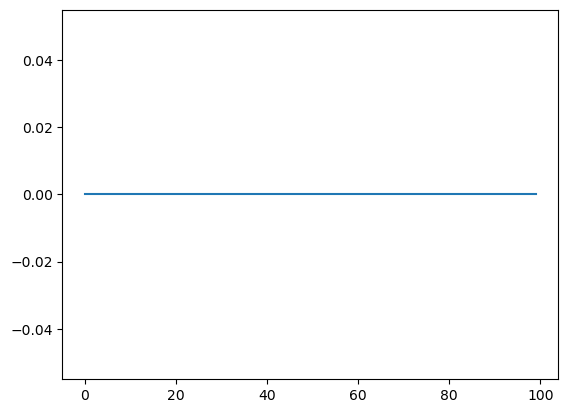

In [27]:
plt.plot(train_losses)
plt.show()

In [19]:
torch.save(model.state_dict(), 'LSTM_model.pt')

In [ ]:
with torch.no_grad():
    for inputs,labels in test_loader:  
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        
        loss_sum += criterion(outputs,labels)
        print(outputs,labels)

In [22]:
model.eval()
loss_sum = 0
correct = 0
cnt_signal = 0
catch_signal = 0 
preds = []
ans = []
with torch.no_grad():
    for inputs,labels in test_loader:  
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        
        loss_sum += criterion(outputs,labels)
        
        preds.append(outputs.to('cpu').detach().numpy().copy())
        ans.append(labels.to('cpu').detach().numpy().copy())
        
        pred = outputs.argmax(1)
        ans_label = labels.argmax(1)
        #ans = labels
        
        correct += sum([ans_label[i]==pred[i]for i in range(len(ans_label))]) 
        cnt_signal += sum([ans_label[i]==1 for i in range(len(ans_label))]) 
        catch_signal += sum([pred[i]==1 for i in range(len(ans_label))]) 
        
print(f"Loss:{loss_sum.item()/len(test_data)},Accuracy:{100*correct/len(test_data)}%({correct}/{len(test_data)})")
print(f"Catch Precision:{100*catch_signal/cnt_signal}%({catch_signal}/{cnt_signal})")


Loss:31.526750230087014,Accuracy:100.0%(1494/1494)
Catch Precision:nan%(0/0)


[array([[52.458]], dtype=float32),
 array([[52.522]], dtype=float32),
 array([[52.586]], dtype=float32),
 array([[52.65]], dtype=float32),
 array([[52.714]], dtype=float32),
 array([[52.778]], dtype=float32),
 array([[52.834]], dtype=float32),
 array([[52.89]], dtype=float32),
 array([[52.946]], dtype=float32),
 array([[53.002]], dtype=float32),
 array([[53.058]], dtype=float32),
 array([[53.114]], dtype=float32),
 array([[53.17]], dtype=float32),
 array([[53.226]], dtype=float32),
 array([[53.282]], dtype=float32),
 array([[53.338]], dtype=float32),
 array([[53.394]], dtype=float32),
 array([[53.45]], dtype=float32),
 array([[53.506]], dtype=float32),
 array([[53.562]], dtype=float32),
 array([[53.618]], dtype=float32),
 array([[53.674]], dtype=float32),
 array([[53.756]], dtype=float32),
 array([[53.838]], dtype=float32),
 array([[53.92]], dtype=float32),
 array([[54.002]], dtype=float32),
 array([[54.084]], dtype=float32),
 array([[54.166]], dtype=float32),
 array([[54.222]], dtype=

In [23]:
fpr, tpr, thresholds = roc_curve(ans, preds)
plt.plot(fpr, tpr, marker='o')

ValueError: unknown format is not supported